# 📈 Stock Price Trend Prediction using Machine Learning

This project uses technical indicators and historical stock data to predict stock price movement (up/down) and generate buy/sell signals.  
We explore data analysis, feature engineering, model training, and backtesting.


📥 Importing Required Libraries

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

📈 2. Downloading Stock Data

In [14]:
data = yf.download("RELIANCE.NS", start="2018-01-01", end="2024-01-01")

C:\Users\Punit Tiwari\AppData\Local\Temp\ipykernel_29368\1304125483.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("RELIANCE.NS", start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


## ⚙️ Feature Engineering using Technical Indicators

We extract meaningful features from the stock price data using popular **technical indicators**. These features will help our machine learning model better understand stock price trends.

- **SMA (Simple Moving Average)**: 20-day average of closing prices.
- **EMA (Exponential Moving Average)**: 20-day exponentially weighted moving average.
- **RSI (Relative Strength Index)**: 14-day momentum oscillator that measures the speed and change of price movements.
- **MACD (Moving Average Convergence Divergence)**: Difference between 12-day EMA and 26-day EMA.
- **MACD Signal**: 9-day EMA of the MACD line, used to generate signals.
- **Bollinger Bands**: High and low bands set 2 standard deviations from a 20-day SMA, used to detect volatility.

After computing these indicators, we drop any rows with missing values to ensure clean input for modeling.


In [15]:
# Drop NA just in case
data.dropna(inplace=True)

# SMA and EMA
sma = SMAIndicator(close=data['Close'].squeeze(), window=20)

data['SMA_20'] = sma.sma_indicator()

ema = EMAIndicator(close=data['Close'].squeeze(), window=20)
data['EMA_20'] = ema.ema_indicator()

# RSI
rsi = RSIIndicator(close=data['Close'].squeeze(), window=14)
data['RSI'] = rsi.rsi()

# MACD
macd = MACD(close=data['Close'].squeeze())
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

# Bollinger Bands
bb = BollingerBands(close=data['Close'].squeeze(), window=20)
data['BB_High'] = bb.bollinger_hband()
data['BB_Low'] = bb.bollinger_lband()

# Drop rows with NaN values caused by indicators
data.dropna(inplace=True)


## 🎯 Defining the Target and Features

To train a machine learning model, we need to define a **target variable** (what we want to predict) and the **input features** (what the model will use to make predictions).

- **Target Variable**: We define a binary classification target:
  - `1` if the **next day's closing price increases by more than 1%**
  - `0` otherwise

This helps the model predict **buy signals** based on whether it expects a significant price rise.

- **Input Features**: We use the technical indicators calculated earlier:
  - `SMA_20`, `EMA_20`: Trend indicators
  - `RSI`: Momentum indicator
  - `MACD`, `MACD_signal`: Trend-following momentum indicators
  - `BB_High`, `BB_Low`: Volatility bands

These features form the basis of our model input `X`, while `y` represents the target label.


In [16]:
# Predict if next day's % change > 1%
data['Target'] = (data['Close'].pct_change().shift(-1) > 0.01).astype(int)

# Define features for ML
features = ['SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'BB_High', 'BB_Low']
X = data[features]
y = data['Target']


## 🤖 Model Training and Accuracy Evaluation

We now train a **Gradient Boosting Classifier (XGBoost)** on our historical stock data to predict future price movements.

- We split the data using an **80/20 time-based split** (no shuffling) to preserve the chronological order, which is crucial in financial time series.
- The **XGBoost model** is configured with:
  - `max_depth = 4`: Limits tree depth to prevent overfitting
  - `learning_rate = 0.05`: Slower learning for better generalization
  - `n_estimators = 100`: Number of boosting rounds
  - `subsample` and `colsample_bytree` help reduce overfitting

After training, we predict on the test set and evaluate performance using **accuracy**, which gives the proportion of correct predictions


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


c:\Users\Punit Tiwari\Desktop\IMPORTANT\stock_trend\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:57:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracy: 0.8482758620689655


## 📊 Model Predictions: Actual vs Predicted

We now visualize how well the model performs on unseen data. The plot below compares:

- The **actual labels** (`True`) — whether the next day's price increased by more than 1%
- The **predicted labels** by our trained XGBoost model

Each point corresponds to a date in the test set:
- `1` represents a predicted or actual "Up" movement (greater than 1% return)
- `0` means "No significant increase"

> 🔍 This visual helps us inspect the alignment between model predictions and real market behavior.


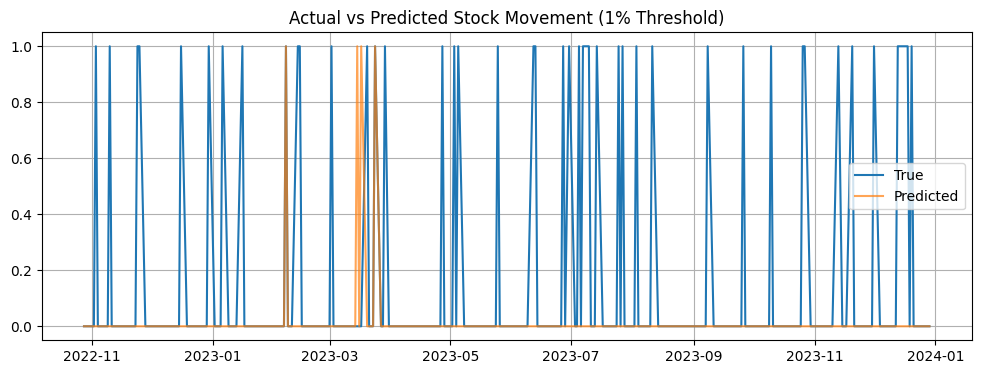

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(data.index[-len(y_test):], y_test.values, label='True')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Stock Movement (1% Threshold)")
plt.grid()
plt.show()


## 💹 Buy/Sell Signals Generated by Model

After training our XGBoost model to predict significant price increases, we use it to generate **buy/sell signals**:

- ✅ **Buy Signal (↑ green triangle):** Model predicts price will increase by more than 1% next day.
- ❌ **Sell Signal (↓ red triangle):** Model predicts no significant price movement.

We overlay these predictions on the stock price chart for better interpretability.

> 📈 This helps visualize how the model's predictions align with actual market movements, enabling future trading strategy analysis.


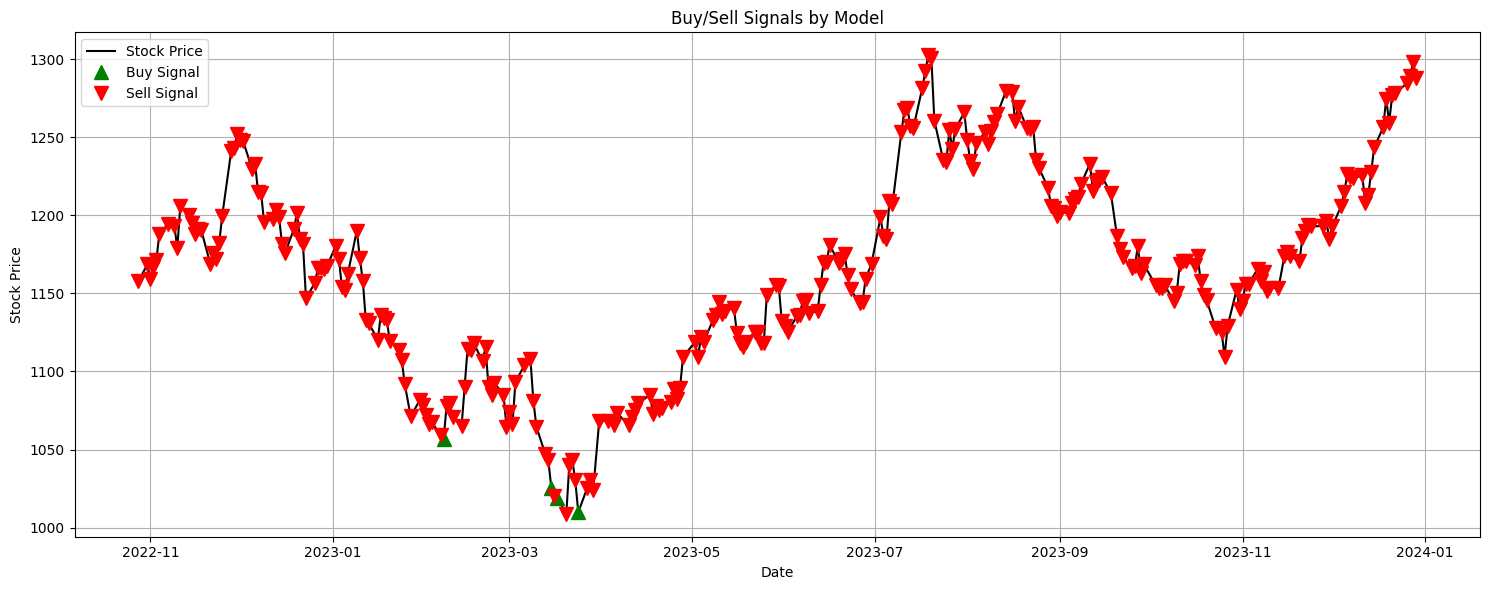

In [19]:

# Assign predictions and Close price to X_test
X_test['Prediction'] = y_pred
X_test['Close'] = data.loc[X_test.index, 'Close']

# Plotting the price and signals
plt.figure(figsize=(15, 6))
plt.plot(X_test.index, X_test['Close'], label='Stock Price', color='black')

# Plot Buy signals (Prediction = 1)
plt.plot(
    X_test[X_test['Prediction'] == 1].index,
    X_test[X_test['Prediction'] == 1]['Close'],
    '^', markersize=10, color='green', label='Buy Signal'
)

# Plot Sell signals (Prediction = 0)
plt.plot(
    X_test[X_test['Prediction'] == 0].index,
    X_test[X_test['Prediction'] == 0]['Close'],
    'v', markersize=10, color='red', label='Sell Signal'
)

plt.title('Buy/Sell Signals by Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Visualizing Prediction Performance and Distribution

To better understand the model's behavior and decision-making trends, we visualize three key distributions using pie charts:

1. **Prediction Accuracy Breakdown**  
   Shows the proportion of correct vs incorrect predictions made by the model on the test data.

2. **Actual Distribution of Buy/Sell Days**  
   Illustrates the true proportion of "buy" (when stock rose >1% next day) vs "sell" days in the test set.

3. **Model Prediction Bias**  
   Highlights whether the model is biased toward predicting buy or sell signals, regardless of ground truth.

These charts help assess not only the model's accuracy but also its behavioral bias and alignment with real-world trends.


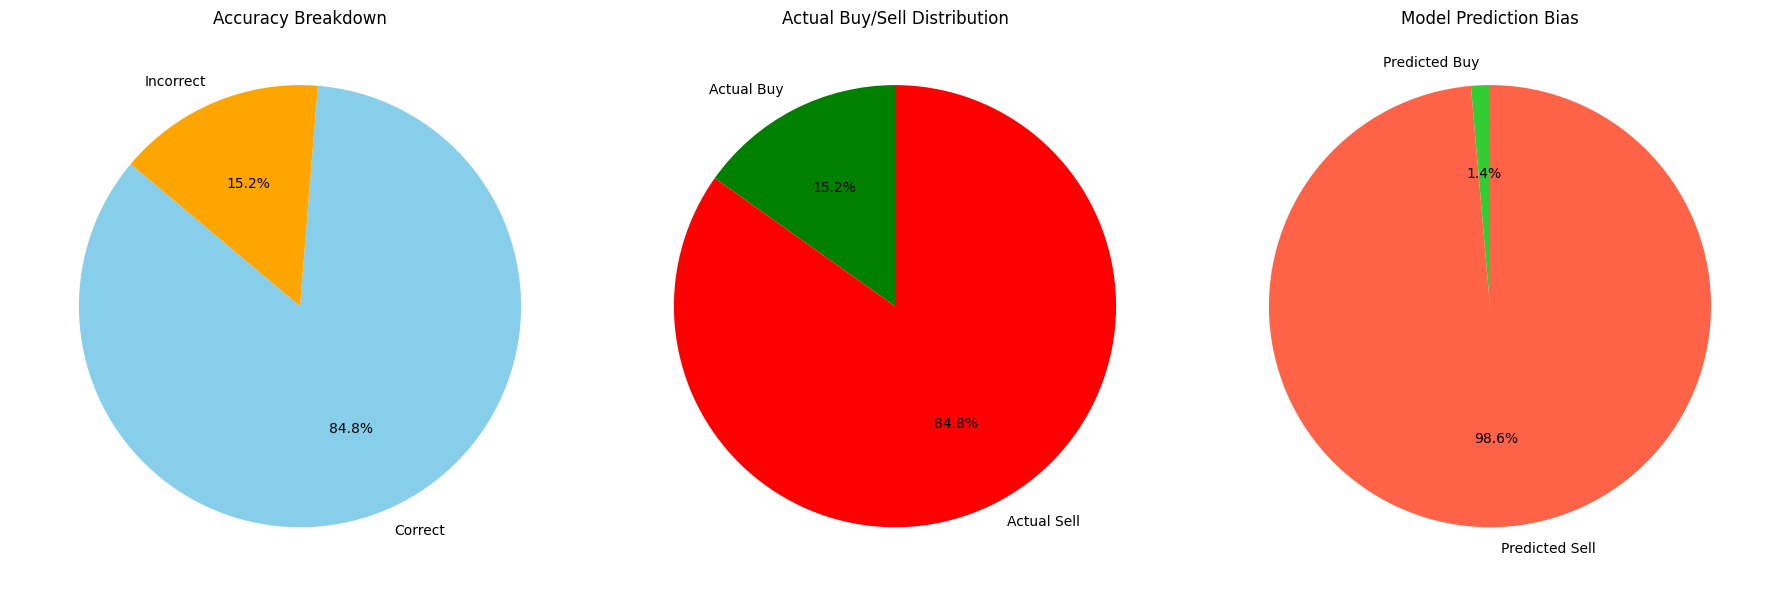

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# 1. Prediction Accuracy Breakdown
cm = confusion_matrix(y_test, y_pred)
correct = cm[0][0] + cm[1][1]
incorrect = cm[0][1] + cm[1][0]

labels = ['Correct', 'Incorrect']
sizes = [correct, incorrect]
colors = ['skyblue', 'orange']
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[0].set_title('Accuracy Breakdown')

# 2. Actual Distribution
true_buy = sum(y_test == 1)
true_sell = sum(y_test == 0)

labels = ['Actual Buy', 'Actual Sell']
sizes = [true_buy, true_sell]
colors = ['green', 'red']
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Actual Buy/Sell Distribution')

# 3. Model Prediction Bias
model_buy = sum(y_pred == 1)
model_sell = sum(y_pred == 0)

labels = ['Predicted Buy', 'Predicted Sell']
sizes = [model_buy, model_sell]
colors = ['limegreen', 'tomato']
axes[2].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[2].set_title('Model Prediction Bias')

# Equal aspect ratio and layout
for ax in axes:
    ax.axis('equal')

plt.tight_layout()
plt.show()


📊 Backtesting LSTM/GRU Strategy on Stock Prices

This section simulates a simple backtesting of a stock trading strategy based on LSTM/GRU predictions.  
The simulation assumes:

- Initial capital: ₹100,000  
- Buy when model predicts upward trend (1)  
- Sell when model predicts downward trend (0)  
- No transaction costs or slippage considered


C:\Users\Punit Tiwari\AppData\Local\Temp\ipykernel_29368\2763450.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(row['Close'])
C:\Users\Punit Tiwari\AppData\Local\Temp\ipykernel_29368\2763450.py:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  prediction = int(row['Prediction'])


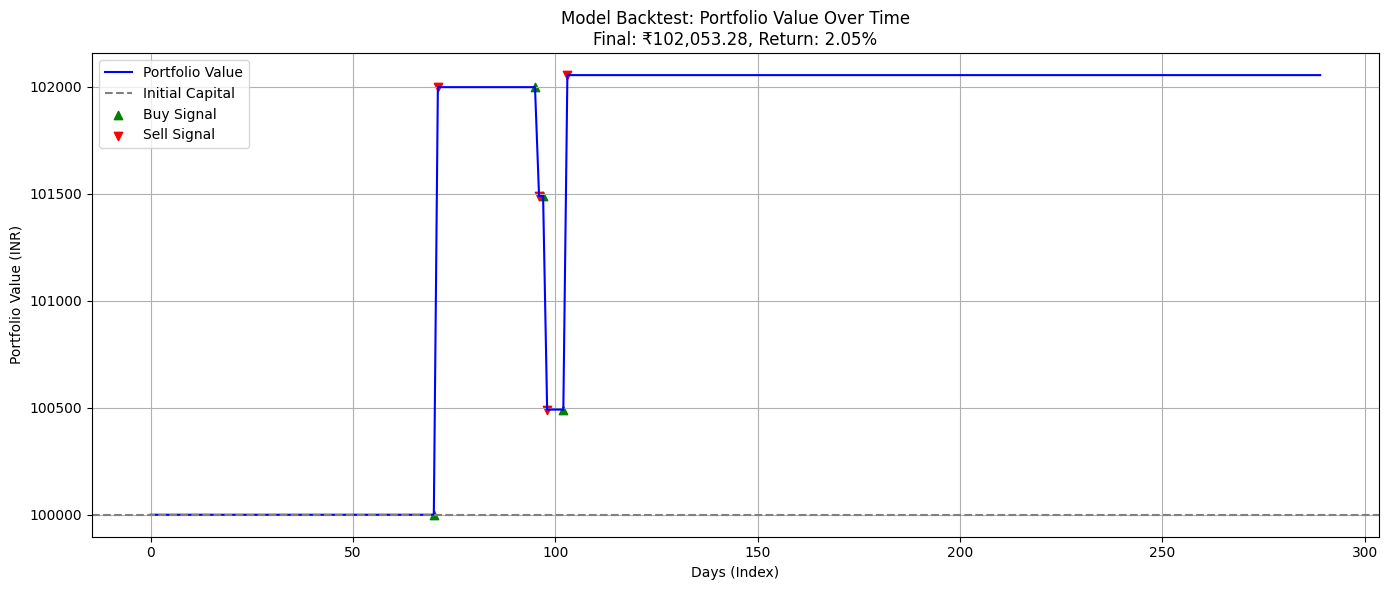

📊 Final Portfolio Value: ₹102,053.28
💰 Profit: ₹2,053.28
📈 Return: 2.05%


In [21]:
# Initial setup
initial_cash = 100000
cash = initial_cash
position = 0
portfolio_value = []

buy_signals = []
sell_signals = []

# Iterate through test data
for i in range(len(X_test)):
    row = X_test.iloc[i]
    price = float(row['Close'])
    prediction = int(row['Prediction'])

    # Buy
    if prediction == 1 and cash > 0:
        position = cash / price
        cash = 0
        buy_signals.append(i)

    # Sell
    elif prediction == 0 and position > 0:
        cash = position * price
        position = 0
        sell_signals.append(i)

    total_value = cash + position * price
    portfolio_value.append(total_value)

# Final metrics
final_value = portfolio_value[-1]
profit = final_value - initial_cash
returns_percent = (profit / initial_cash) * 100

# Plot Portfolio Value
plt.figure(figsize=(14, 6))
plt.plot(range(len(portfolio_value)), portfolio_value, label='Portfolio Value', color='blue')
plt.axhline(y=initial_cash, color='gray', linestyle='--', label='Initial Capital')

# Plot Buy/Sell Markers
plt.scatter(buy_signals, [portfolio_value[i] for i in buy_signals], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals, [portfolio_value[i] for i in sell_signals], marker='v', color='red', label='Sell Signal')

# Labels and grid
plt.title(f'Model Backtest: Portfolio Value Over Time\nFinal: ₹{final_value:,.2f}, Return: {returns_percent:.2f}%')
plt.xlabel('Days (Index)')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print(f"📊 Final Portfolio Value: ₹{final_value:,.2f}")
print(f"💰 Profit: ₹{profit:,.2f}")
print(f"📈 Return: {returns_percent:.2f}%")
